In [1]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
class Config:
    # Origin image size
    input_size = 28
    # Input shape of image
    input_shape = [input_size, input_size, 1]
    # Learning rate of the Model
    learning_rate = 0.001
    # Weight decay rate of the Model
    weight_decay = 0.0001
    # Batch size of the Model
    batch_size = 256
    num_classes = 10
    num_epochs = 30
    image_size = 28
    patch_size = 6
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim
    ]
    transformer_layers = 8
    mlp_head_units = [2048, 1024]

In [4]:
def sample_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    plt.show()

In [5]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Display some information about the dataset
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

11490434/11490434 [==============================] - 0s 0us/step
Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [6]:
train = np.array(train_images).reshape((-1, Config.input_size, Config.input_size, 1))
test = np.array(test_images).reshape((-1, Config.input_size, Config.input_size, 1))

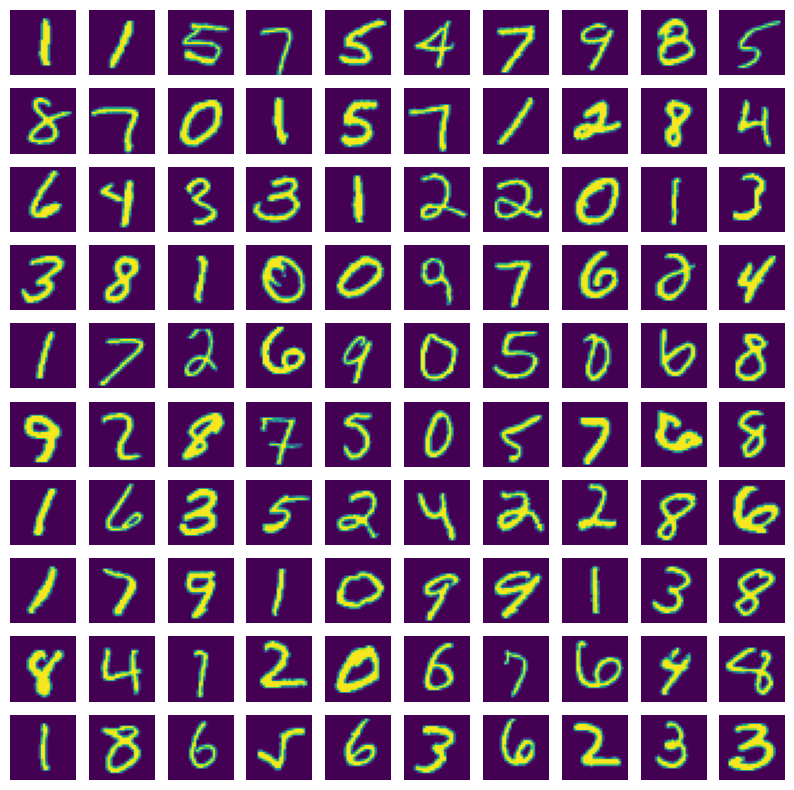

In [7]:
indices = np.random.choice(train.shape[0], 100)
sample_images(train[indices].squeeze(), 10, 10)

In [8]:
augmentation_layer = tf.keras.Sequential([
    keras.layers.Input(Config.input_shape),
    keras.layers.experimental.preprocessing.Normalization(),
    keras.layers.experimental.preprocessing.Resizing(Config.image_size, Config.image_size),
    keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
    keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
])

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(256, 28, 28, 1)
Image size: 28 X 28
Patch size: 6 X 6
Patches per image: 16
Elements per patch: 36


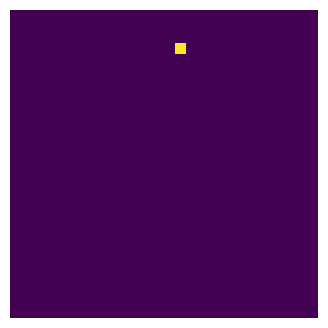

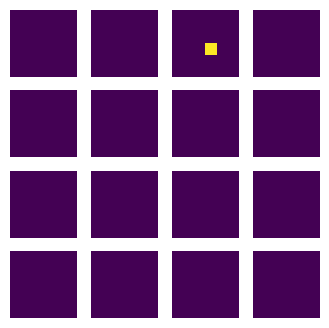

In [11]:
plt.figure(figsize=(4, 4))
start_index = np.random.choice(train.shape[0] // 2)
image = train[start_index: start_index + Config.batch_size]
plt.imshow(np.squeeze(image[0]).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor(image), size=(Config.image_size, Config.image_size)
)
print(resized_image.shape)
patches = Patches(Config.patch_size)(resized_image)
print(f"Image size: {Config.image_size} X {Config.image_size}")
print(f"Patch size: {Config.patch_size} X {Config.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (Config.patch_size, Config.patch_size))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [12]:
class PatchEncoder(layers.Layer):

    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [13]:
def create_vision_transformer():
    # Inputs
    inputs = layers.Input(shape=Config.input_shape)
    # Data Augmentation
    augmented = augmentation_layer(inputs)
    # Patches
    patches = Patches(Config.patch_size)(augmented)
    encoder_patches = PatchEncoder(Config.num_patches, Config.projection_dim)(patches)

    for _ in range(Config.transformer_layers):
        # Layer Normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
        # Multi-Head Attention Layer
        attention_output = layers.MultiHeadAttention(
            num_heads=Config.num_heads,
            key_dim=Config.projection_dim,
            dropout=0.1
        )(x1, x1)
        # Skip Connnection 1
        x2 = attention_output + encoder_patches

        # Layer Normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=Config.transformer_units, dropout_rate=0.1)

        # Skip Connnection 2
        encoder_patches = x3 + x2

    representation = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=Config.mlp_head_units, dropout_rate=0.5)

    outputs = layers.Dense(Config.num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [14]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 28, 28, 1)            3         ['input_1[0][0]']             
                                                                                                  
 patches (Patches)           (None, None, 36)             0         ['sequential[0][0]']          
                                                                                                  
 patch_encoder (PatchEncode  (None, 16, 64)               3392      ['patches[0][0]']             
 r)                                                                                           

In [15]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)
checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

In [16]:
history = vit_classifier.fit(train, train_labels, epochs=60, batch_size=Config.batch_size, validation_data=(test, test_labels))

Epoch 1/60
235/235 [==============================] - 23s 38ms/step - loss: 0.5192 - accuracy: 0.8362 - val_loss: 0.1055 - val_accuracy: 0.9674
Epoch 2/60
235/235 [==============================] - 8s 33ms/step - loss: 0.1893 - accuracy: 0.9420 - val_loss: 0.0652 - val_accuracy: 0.9805
Epoch 3/60
235/235 [==============================] - 7s 32ms/step - loss: 0.1438 - accuracy: 0.9563 - val_loss: 0.0594 - val_accuracy: 0.9813
Epoch 4/60
235/235 [==============================] - 8s 33ms/step - loss: 0.1249 - accuracy: 0.9609 - val_loss: 0.0573 - val_accuracy: 0.9829
Epoch 5/60
235/235 [==============================] - 7s 32ms/step - loss: 0.1117 - accuracy: 0.9659 - val_loss: 0.0478 - val_accuracy: 0.9849
Epoch 6/60
235/235 [==============================] - 7s 32ms/step - loss: 0.0999 - accuracy: 0.9686 - val_loss: 0.0464 - val_accuracy: 0.9850
Epoch 7/60
235/235 [==============================] - 7s 32ms/step - loss: 0.0961 - accuracy: 0.9704 - val_loss: 0.0458 - val_accuracy: 0.986

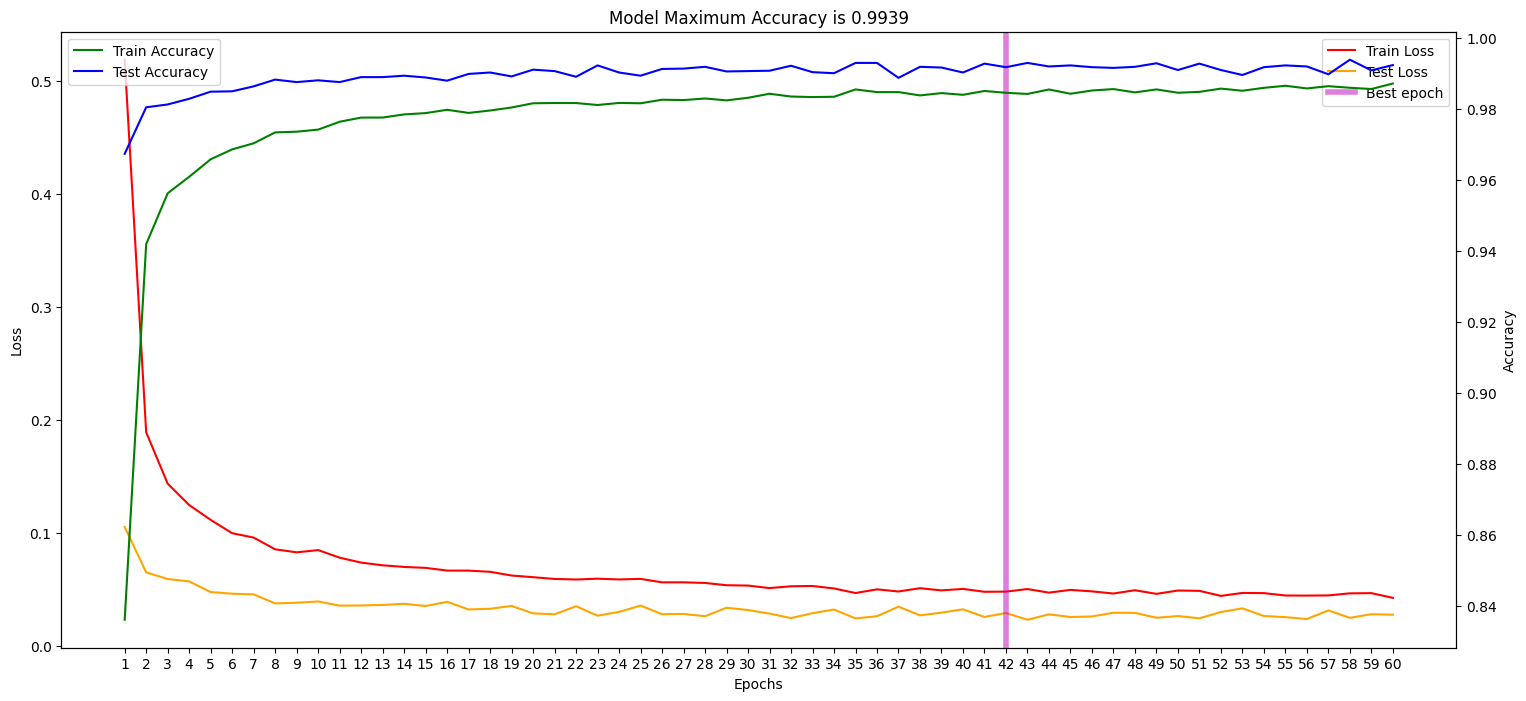

Maximum Test Accuracy:  0.9939000010490417
Maximum Train Accuracy:  0.9872000217437744


In [17]:
def plot_history(history, filename, model_name):
  best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
  fig, ax1 = plt.subplots(figsize=(18,8))
  plt.title(' '.join([model_name, 'Maximum Accuracy is %1.4f' % max(history.history['val_accuracy'])]))
  ax1.set_xlabel('Epochs')
  ax1.set_xticks(range(1,61))
  ax1.set_ylabel('Loss')
  ax1.plot(range(1,61), history.history['loss'], 'r', label='Train Loss')
  ax1.plot(range(1,61), history.history['val_loss'], 'orange', label='Test Loss')
  ax1.axvline(best_epoch, color='m', lw=4, alpha=0.5, label='Best epoch')
  ax1.legend()

  ax2 = ax1.twinx()
  ax2.set_ylabel('Accuracy')
  ax2.plot(range(1,61), history.history['accuracy'], 'g', label='Train Accuracy')
  ax2.plot(range(1,61), history.history['val_accuracy'], 'b', label='Test Accuracy')
  ax2.legend()

  plt.savefig(filename)
  plt.show()

#plotting learning curves and labelling them
filename='Model.png'
model_name = 'Model'
plot_history(history, filename, model_name)

print("Maximum Test Accuracy: ", max(history.history['val_accuracy']))
print("Maximum Train Accuracy: ", max(history.history['accuracy']))